In [1]:
%load_ext autoreload
%autoreload 2


## Weird fastai magic

In [2]:
import fastbook

fastbook.setup_book()


## Device selection

In [3]:
import torch

gpu = torch.device("mps")
cpu = torch.device("cpu")
device = cpu


## Gather MNIST data

### Download dataset

In [4]:
from load_mnist_data import load_mnist_data

mnist_path = load_mnist_data()


MNIST data downloaded to /Users/david/.fastai/data/mnist_png


### Datasets and DataLoaders

In [5]:
from load_mnist_data import IMAGE_SHAPE, DataSplit, labeled_data

train_x, train_y = labeled_data(mnist_path, DataSplit.TRAINING, device)
valid_x, valid_y = labeled_data(mnist_path, DataSplit.TESTING, device)

assert train_x.shape == torch.Size([60_000, IMAGE_SHAPE[0] * IMAGE_SHAPE[1]]), (
    "train_x should be a matrix of 60,000 images, each a vector of flattened pixels"
)
assert train_y.shape == torch.Size([60_000]), (
    "train_y should be a vector of 60,000 labels"
)

assert valid_x.shape == torch.Size([10_000, IMAGE_SHAPE[0] * IMAGE_SHAPE[1]]), (
    "valid_x should be a matrix of 10,000 images, each a vector of flattened pixels"
)
assert valid_y.shape == torch.Size([10_000]), (
    "valid_y should be a vector of 10,000 labels"
)


get_stacked_preprocessed_digits is running for digit: 0, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 1, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 2, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 3, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 4, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 5, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 6, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 7, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 8, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 9, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 0, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 1, split: DataSplit.TESTING
get_st

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. 
It looks like this: $[(x_1,y_1), (x_2,y_2), ... (x_n,y_n)]$

In [6]:
train_dataset = list(zip(train_x, train_y))
valid_dataset = list(zip(valid_x, valid_y))

assert len(train_dataset) == 60_000, "training_dset should have 60,000 items"

image, label = train_dataset[0]
assert image.shape == torch.Size(
    [IMAGE_SHAPE[0] * IMAGE_SHAPE[1]]
) and label.shape == torch.Size([]), (
    "Each item in a dataset should be a tuple of an image and a label"
)


Take a look somewhere in a dataset:

tensor(6)

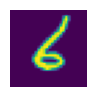

In [7]:
from fastai.basics import show_image

image, label = train_dataset[40_000]

show_image(image.view((IMAGE_SHAPE)))
label


When we pass a dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing collections of independent and dependent variables.

In [8]:
from fastai.basics import first
from fastai.data.load import DataLoader

# A dataloader with a tiny batch size for playing around
toy_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)


Each training batch is a tuple of two tensors:

In [9]:
first_training_batch = first(toy_dataloader)

assert isinstance(first_training_batch, tuple), "first_training_batch should be a tuple"
assert len(first_training_batch) == 2, "first_training_batch should have length 2"


The first element is a tensor of images and the second is a tensor of labels. Both have the same length, which corresponds to the `batch_size` passed to the `DataLoader` constructor above.

In [10]:
images, labels = first_training_batch
assert images.shape == torch.Size([2, IMAGE_SHAPE[0] * IMAGE_SHAPE[1]])
assert labels.shape == torch.Size([2])


The first image and label in the batch:

tensor(2)

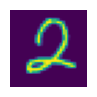

In [11]:
show_image(first(images).view(IMAGE_SHAPE))
first(labels)


### Turning labels into targets

In [12]:
from torch import Tensor
from torch.nn.functional import one_hot


def encode_one_hot_targets(labels: Tensor, num_classes=10) -> Tensor:
    return one_hot(labels, num_classes).float()


## As a "manual" linear model

### Initialize parameters

In the book the model has to differentiate between 2 digits, so the model has a single output. 0.0 is used as some kind of threshold: any values greater than 0 represent a prediction for one digit, the others represent the other digit. For this 2-digit model, `train_y` is a vector of 1s for one digit and 0s for the other digit. (And then unsqueezed to a second dimension of size 1).

0 is at the center of the model outputs distribution, then they switch it to 0.5 (that is, all values between 0 and 1) using **sigmoid**.

I want to switch the model from having one input $y_1$ (probability of input being digit a, and $y_2=1-y_1$) to 10 outputs, each corresponding to the probability of
the input matching a particular digit. The combined probabilities will be normalized to add to 1.

In [13]:
count_outputs = 10


In [14]:
from model import init_params

weights = init_params((IMAGE_SHAPE[0] * IMAGE_SHAPE[1], count_outputs), device)
biases = init_params(count_outputs, device)


### The forward computation

How I think the `batch @ weights + bias`, equation operates in a linear model with 10 outputs: it has 10 sets of parameters and 10 biases. So I'm imagining it's just that equation once per output, with the same input data, independently and in parallel.

#### Run it once for a single image

In [15]:
first_image = train_x[0]
print(f"Shape of the first image: {first_image.shape}")

# the T is transpose, flipping weights from [784, count_outputs] to [count_outputs, 784]
transposed_weights = weights.T
print(f"Shape of transposed weights: {transposed_weights.shape}")

element_wise_product = first_image * transposed_weights
print(f"Shape of element-wise multiplication: {element_wise_product.shape}")

model_result = element_wise_product.sum() + biases
print(f"Shape of model result: {model_result.shape}")
print(f"Model result: {model_result}")


Shape of the first image: torch.Size([784])
Shape of transposed weights: torch.Size([10, 784])
Shape of element-wise multiplication: torch.Size([10, 784])
Shape of model result: torch.Size([10])
Model result: tensor([-8.6374, -8.6943, -8.6855, -8.6645, -8.1637, -8.4328, -8.4474, -8.6370, -8.6553, -8.3612], grad_fn=<AddBackward0>)


#### Run it once for a batch data using broadcasting (no loops!)

In [16]:
input = train_x  # the whole dataset -- it still feels instantaneous

print(f"Shape of batch: {input.shape}")
print(f"Shape of weights: {weights.shape}")
print(f"Shape of bias: {biases.shape}")


# Here is one of the two magic equations (the other one is the activation
# function), equivalent to doing the run above but for each image in the batch
# (in this case the full training set).
model_result = input @ weights + biases

print(f"Shape of results: {model_result.shape}")


Shape of batch: torch.Size([60000, 784])
Shape of weights: torch.Size([784, 10])
Shape of bias: torch.Size([10])
Shape of results: torch.Size([60000, 10])


## Intuition about loss

In [17]:
from fastai.torch_core import tensor
from torch.nn.functional import cross_entropy
from training import calculate_loss

_targets = tensor(
    [
        [1, 0, 0],
        [0, 0, 1],
    ],
    dtype=torch.float,
    device=device,
)

_preds_worse = tensor(
    [
        [0.3, 0.5, 0.2],
        [0.7, 0.1, 0.2],
    ],
    dtype=torch.float,
    device=device,
)

_preds_better = tensor(
    [
        [0.4, 0.5, 0.1],
        [0.6, 0.1, 0.3],
    ],
    dtype=torch.float,
    device=device,
)

assert calculate_loss(_preds_worse, _targets) == 0.7 + 0.8, "wrong loss calculation"
assert calculate_loss(_preds_better, _targets) == 0.6 + 0.7, "wrong loss calculation"
assert calculate_loss(_preds_worse, _targets) > calculate_loss(
    _preds_better, _targets
), "wrong loss comparison (calculate_loss)"

assert cross_entropy(_preds_worse, _targets) > cross_entropy(_preds_better, _targets), (
    "wrong loss comparison (cross-entropy)"
)


## Train

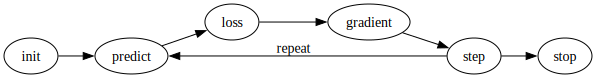

In [18]:
from fastbook import gv

gv("""
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
""")


#### Instantiate the model


In [19]:
from model import Linear, ReLU, Sequential

intermediate_features = 32
model = Sequential(
    [
        Linear(
            in_features=IMAGE_SHAPE[0] * IMAGE_SHAPE[1],
            out_features=intermediate_features,
            init_params_function=init_params,
            device=device,
        ),
        ReLU(device=device),
        Linear(
            in_features=intermediate_features,
            out_features=count_outputs,
            init_params_function=init_params,
            device=device,
        ),
    ]
)


#### Run the training

In [20]:
import time

from fastai import optimizer
from normalize import normalize_log_softmax
from torch.nn.functional import cross_entropy
from training import train_model

start_time = time.time()

# train_data = (
#     train_x,
#     encode_one_hot_targets(train_y),
# )

train_data = DataLoader(train_dataset, batch_size=256, shuffle=True, device=device)

valid_data = (valid_x, encode_one_hot_targets(valid_y))

accuracies = list()

learning_rate = 0.0001
epochs = 1000

for epoch, acc in train_model(
    train_data,
    valid_data,
    model,
    normalizer=normalize_log_softmax,
    loss_function=cross_entropy,
    optimizer=optimizer.SGD(params=model.params(), lr=learning_rate),
    epochs=epochs,
):
    elapsed = time.time() - start_time
    accuracies.append(acc)
    if epoch % 100 == 0:
        print(f"Time={elapsed:.2f}s, epoch: {epoch}, accuracy: {acc}")


Time=0.24s, epoch: 0, accuracy: 0.09440000355243683
Time=21.93s, epoch: 100, accuracy: 0.4821999967098236
Time=44.33s, epoch: 200, accuracy: 0.5713000297546387
Time=65.86s, epoch: 300, accuracy: 0.6097000241279602
Time=87.76s, epoch: 400, accuracy: 0.6330000162124634
Time=109.22s, epoch: 500, accuracy: 0.6480000019073486
Time=130.74s, epoch: 600, accuracy: 0.6603000164031982
Time=152.24s, epoch: 700, accuracy: 0.6697999835014343
Time=173.71s, epoch: 800, accuracy: 0.6777999997138977
Time=195.26s, epoch: 900, accuracy: 0.6873999834060669


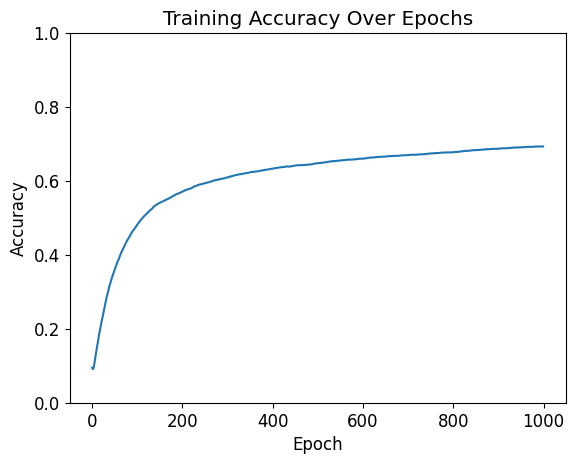

In [21]:
from training import plot_accuracies

plot_accuracies(accuracies)


In [22]:
from notify_complete import notify_complete

notify_complete()


Questions after all of this:
- How to choose the number of intermediate features?
- How to play with LRs? Should the LR vary within a training run? With which shape? Is a smaller LR always more conductive to correct learning, even if it takes longer, or is it more likely to get stuck in a local minimum?
- What is the effect of batch sizes on learning? What are the trade offs? 
- How to saturate the GPU? How to profile bottlenecks?
- Speaking of which, what's the deal with `DataLoader`? Why so slow?
- How does batching help with learning (not only with speed)?
- I'm bruteforcing the epochs. . .
- Use `DataLoader` anyway, on the CPU?